In [261]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import re
#from PIL import Image
from keras.preprocessing import image

In [262]:
IMAGE_WIDTH = 64    
IMAGE_HEIGHT = 64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "./Data/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


In [263]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
df = df.sample(frac=1).reset_index(drop=True)
df = df[:15500]

print('number of elements = ' , len(df))

number of elements =  15500


In [264]:
train = tf.keras.utils.image_dataset_from_directory(
    base_path,
    class_names=['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass'],
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset="training",
    seed=123
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.


In [265]:
validate=tf.keras.utils.image_dataset_from_directory(
    base_path,
    class_names=['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass'],
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [266]:
class_names = train.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

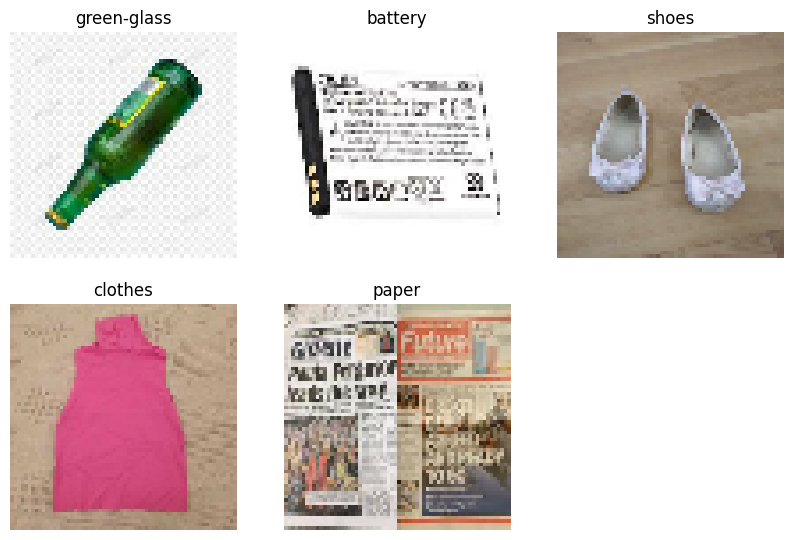

In [267]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [268]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [269]:
model = keras.Sequential([
    keras.layers.Normalization(),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="same"),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="same"),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="same"),
    keras.layers.Convolution2D(kernel_size=4, filters=8, padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(12, activation="softmax")
])

In [270]:
model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
model.build(input_shape=(50,IMAGE_WIDTH,IMAGE_HEIGHT,3))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliza  (50, 64, 64, 3)          7         
 tion)                                                           
                                                                 
 conv2d_44 (Conv2D)          (50, 64, 64, 8)           392       
                                                                 
 conv2d_45 (Conv2D)          (50, 64, 64, 8)           1032      
                                                                 
 max_pooling2d_22 (MaxPoolin  (50, 32, 32, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (50, 32, 32, 8)           1032      
                                                                 
 conv2d_47 (Conv2D)          (50, 29, 29, 8)         

In [271]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [272]:
model.fit(train, validation_data=validate, epochs=75, batch_size=50)

Epoch 1/100
207/388 [===============>..............] - ETA: 13s - loss: 7.5118 - accuracy: 0.3184

KeyboardInterrupt: 

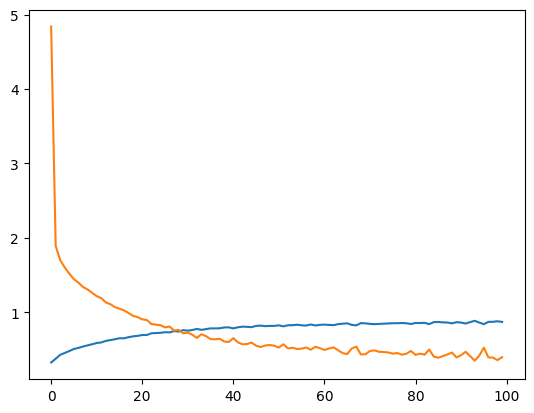

In [ ]:
history = _
ax = plt.subplot()
ax.plot(history.history["accuracy"], label="Accuracy")
ax.plot(history.history["loss"], label="Validation Accuracy")

In [ ]:
model.save("./Models/64-75/")

INFO:tensorflow:Assets written to: ./Models/32-100/assets


INFO:tensorflow:Assets written to: ./Models/32-100/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmp4t6jok07/assets


INFO:tensorflow:Assets written to: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmp4t6jok07/assets
2023-02-11 15:24:12.512060: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-11 15:24:12.512080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-11 15:24:12.512202: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmp4t6jok07
2023-02-11 15:24:12.514249: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-11 15:24:12.514261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/8h/r_p0xb3j6m57h6qffsf0kmp00000gn/T/tmp4t6jok07
2023-02-11 15:24:12.521490: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-11 15:24:12.597711: I tensorflow/cc/saved_model/loader.cc:213] Running initialization